![image source: https://openart.ai/discovery/md-438e164b-250d-4dca-8989-cda9e5dda6ec](images/2023-04-26-amazon-rekognition-custom-labels.jpg)

## Credits
This post takes inspiration from the book [Computer Vision on AWS](https://github.com/PacktPublishing/Computer-Vision-on-AWS). Chapter 3 of the book dives into Amazon Rekognition and covers many more details than this post. The book used [Packt logos](https://github.com/PacktPublishing/Computer-Vision-on-AWS/tree/main/03_RekognitionCustomLabels) as an example for Rekognition Custom Labels. However, I have used the `Raspberry Pi` logo instead to make it more interesting. To download the Raspberry Pi images from the internet, I have relied on [FastAI](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) and [Duckduckgo_search](https://pypi.org/project/duckduckgo-search/) libraries.

## Introduction

[Amazon Rekognition Custom Labels](https://aws.amazon.com/rekognition/custom-labels-features/) is a fully managed computer vision service that allows developers to build custom models to classify and identify objects in images that are specific and unique to your business. `Rekognition Custom Labels doesn’t require you to have any prior computer vision expertise`. For example, you can find your logo in social media posts, identify your products on store shelves, classify machine parts in an assembly line, distinguish healthy and infected plants, or detect animated characters in videos.

Developing a custom model to analyze images is a significant undertaking that requires time, expertise, and resources, often taking months to complete. Additionally, it often requires thousands or tens of thousands of hand-labeled images to provide the model with enough data to accurately make decisions. Generating this data can take months to gather and requires large teams of labelers to prepare it for use in machine learning (ML).

`Rekognition Custom Labels` builds off of the existing capabilities of [Amazon Rekognition](https://aws.amazon.com/rekognition/), which are already trained on tens of millions of images across many categories. Instead of thousands of images, you simply need to upload a small set of training images (typically a few hundred images or less) that are specific to your use case using the Amazon Rekognition console. If the images are already labeled, you can begin training a model in just a few clicks. If not, you can label them directly on the Rekognition Custom Labels console, or use Amazon SageMaker Ground Truth to label them. `Rekognition Custom Labels uses transfer learning and AutoML to automatically inspect the training data, select the right model framework and algorithm, optimize the hyperparameters, and train the model`. When you’re satisfied with the model accuracy, you can start hosting the trained model with just one click.

::: {.callout-note}

This introduction is adapted from **AWS Machine Learning Blog** post [Announcing the launch of the model copy feature for Amazon Rekognition Custom Labels](https://aws.amazon.com/blogs/machine-learning/announcing-the-launch-of-the-model-copy-feature-for-amazon-rekognition-custom-labels/)

:::

In this post, I have explained how to `create a custom object detection model` using the `Reckognition custom labels` service. Our goal will be to create a model that can analyze images and locate the [Raspberry Pi](https://www.raspberrypi.org/) logo on its boards.

![](images/2023-04-26-amazon-rekognition-custom-labels/COLOUR-Raspberry-Pi-Symbol-Registered.png)

## Environment
This notebook is created with `Amazon SageMaker Studio` envionment. Details of the environment are given below

* **GitHub**: [2022-10-10-pytorch-linear-regression.ipynb](https://github.com/hassaanbinaslam/myblog/blob/main/posts/2023-04-26-amazon-rekognition-custom-labels.ipynb)
* **Open In Colab**: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hassaanbinaslam/myblog/blob/main/posts/2023-04-26-amazon-rekognition-custom-labels.ipynb)

![](images/2023-04-26-amazon-rekognition-custom-labels/notebook-env.png)

## Step 1: Download and clean Raspberry Pi images

We need to collect relevant images to successfully train a model that can detect Raspberry Pi logos on computer boards. We can use the `Google Images` search to find such images. But downloading many pictures from Google search can take much work to automate. So instead, we can use a different search engine, [DuckDuckGo.com](https://duckduckgo.com/), that provides a more straightforward interface [duckduckgo_search](https://pypi.org/project/duckduckgo-search/) for search. For downloading and resizing images, we will use additional libraries from the `FastAI` ecosystem [fastai](https://github.com/fastai/fastai) and [fastdownload](https://github.com/fastai/fastdownload/tree/master/).

In [2]:
%%writefile requirements.txt
duckduckgo-search==2.8.6
fastai==2.7.12 
fastdownload==0.0.7 
fastcore==1.5.29

Overwriting requirements.txt


In [3]:
%%capture
!pip install -r requirements.txt 

# Install required libraries
# 1. `duckduckgo_search` to search for words, documents, images, news, maps and text translation using the DuckDuckGo.com search engine.
# 2. `fastdownload` to easily download, verify, and extract archives
# 3. `fastai` to open, visualize, and transform images
# 4. `fastcore` extends Python list functionality

In [4]:
from duckduckgo_search import ddg_images
from fastcore.all import *

# Define a function to search for images using DuckDuckGo.com search engine for the provided term. It returns the URL of the searched image.
# By default, it will try to find 200 images matching the searched word.
def search_images(term, max_images=200):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot("image")


# Define search term. In our case it is "raspberry pi board"
searches = {
    "pi": "raspberry pi board",
}

# Test the search function and display URLs returned
urls = search_images(searches["pi"], max_images=1)
urls[0]

Searching for 'raspberry pi board'


'https://www.watelectronics.com/wp-content/uploads/2019/07/Model-A-Raspberry-Pi-Board.jpg'

Above, we have defined a function that can be used to search images and return their URLs. Next, we can use these URLs to download and save images to a local directory.

In [5]:
from pathlib import Path

# Define a local path to store downloaded images
local_dir = "./assets/2023-04-26-amazon-rekognition-custom-labels/"

# Create the directory if it does not exist
local_path = Path(local_dir)
local_path.mkdir(parents=True, exist_ok=True)

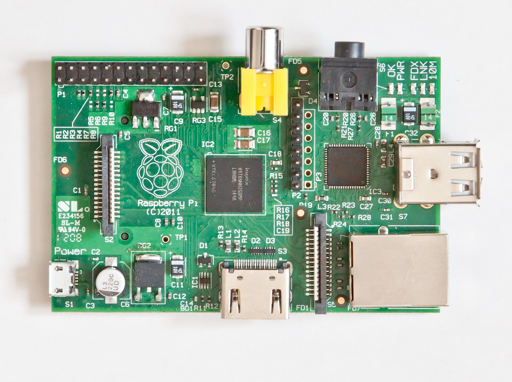

In [6]:
from fastai.vision.all import *
from fastdownload import download_url

# `local_path_raw` is the local directory to store raw downloaded images
local_path_raw = Path(f"{local_path}/raw/")
dest = f"{local_path_raw}/sample-image.jpg"

# Download a sample Raspberry Pi board image
download_url(urls[0], dest, show_progress=True)

# Display the downloaded image
im = Image.open(dest)
im.to_thumb(512, 512)

In the above image, you can see the `Raspberry Pi logo` in the center of the board. That is our target and we want our model to locate it automatically. This sample image shows that our search string is correct, and we can proceed to download similar images.

In [15]:
# Use each search string to search and download images
max_images = 200  # total number of images to search for

for key, value in searches.items():
    # create a separate folder for each searched term
    dest = local_path_raw / key
    dest.mkdir(exist_ok=True, parents=True)

    # download and store the images for provided searched term
    download_images(dest, urls=search_images(value, max_images=max_images))
    resize_images(local_path_raw / key, max_size=800, dest=local_path_raw / key)

Searching for 'raspberry pi board'


At this point, the search and download step is complete. Next, let's count the number of images successfully downloaded to our local directory.

In [8]:
# Check the count of downloaded images
(local_path_raw / "pi").ls()

(#156) [Path('assets/2023-04-26-amazon-rekognition-custom-labels/raw/pi/e3a144d9-5730-4def-9581-c2cc6f26140a.jpg'),Path('assets/2023-04-26-amazon-rekognition-custom-labels/raw/pi/195d40ea-0a1c-4875-a7eb-6f06fc0855cd.jpg'),Path('assets/2023-04-26-amazon-rekognition-custom-labels/raw/pi/5d10c219-ae38-4cfe-b432-96f951e0bb3f.jpg'),Path('assets/2023-04-26-amazon-rekognition-custom-labels/raw/pi/2d0e1737-a72d-4513-bd74-432fae126891.png'),Path('assets/2023-04-26-amazon-rekognition-custom-labels/raw/pi/338f84b5-e583-4925-b3bb-aebc4bc18bd1.jpg'),Path('assets/2023-04-26-amazon-rekognition-custom-labels/raw/pi/c114204b-b97a-455b-bdcc-0e3ee835ad11.png'),Path('assets/2023-04-26-amazon-rekognition-custom-labels/raw/pi/f3a698c6-25b7-4c5f-b17b-95ade57afee0.jpg'),Path('assets/2023-04-26-amazon-rekognition-custom-labels/raw/pi/2c950136-cb8e-4809-ae0b-f115a00e2f2d.jpg'),Path('assets/2023-04-26-amazon-rekognition-custom-labels/raw/pi/5a574d21-5bbb-4214-b9c2-513e014bf348.jpg'),Path('assets/2023-04-26-amazo

We have downloaded the required images (#156 in total), but there is no guarantee that all our photos contain a Raspberry Pi logo. An image without a proper logo is useless for training. So we need to manually verify all the pictures and remove any that does not meet our requirements. This is a manual step and has to be performed *very patiently*. After cleaning all the images, I uploaded them under the `/clean` directory.

In [9]:
# After downloading the images, next step is to manually clean all the images
# After cleaning, check the count of images
local_path_clean = local_path / "clean"
local_path_clean.ls()

(#112) [Path('assets/2023-04-26-amazon-rekognition-custom-labels/clean/d14e3413-0c2f-4a8d-9361-e842633a7fb6.jpg'),Path('assets/2023-04-26-amazon-rekognition-custom-labels/clean/1a623864-2b33-4bce-98e9-5cbc2551afae.jpg'),Path('assets/2023-04-26-amazon-rekognition-custom-labels/clean/228d560d-ab50-4bf5-8a3b-510dcdf89e9a.jpg'),Path('assets/2023-04-26-amazon-rekognition-custom-labels/clean/babf3bb6-fa72-4a53-989d-a34326422e19.jpg'),Path('assets/2023-04-26-amazon-rekognition-custom-labels/clean/95660e55-1566-47cb-912c-2c683b790dcd.jpg'),Path('assets/2023-04-26-amazon-rekognition-custom-labels/clean/9ee061b2-c492-4691-9557-4b848cd16f10.jpg'),Path('assets/2023-04-26-amazon-rekognition-custom-labels/clean/5e0490d6-646d-470e-8257-f3c6742c3a48.jpg'),Path('assets/2023-04-26-amazon-rekognition-custom-labels/clean/a3f1aaa0-3188-414a-b6b6-0e5ce308daf9.jpg'),Path('assets/2023-04-26-amazon-rekognition-custom-labels/clean/3ae6fd96-22fa-404c-a867-48ca3a181f05.jpg'),Path('assets/2023-04-26-amazon-rekogni

Let's display a sample of the cleaned images.

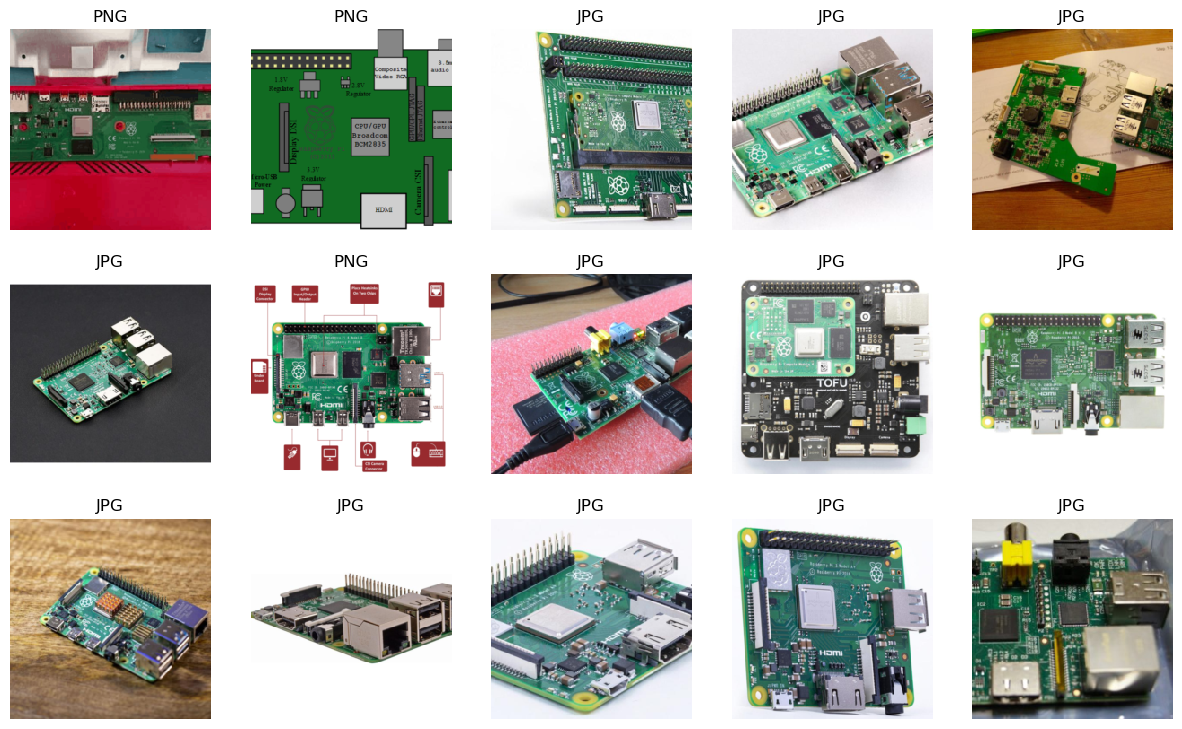

In [11]:
# Define a function to display the extention of the image.
# Note that only JPG and PNG images can be used for training in Rekognition custom labels
def label_func(f):
    return f[-3:].upper()


# Load images from the folder. This function act as a filter to omit files that are not images.
# It does not read images at this point and only return their paths.
files = get_image_files(local_path_clean)

# Use FastAI DataLoader class to read images from the provided paths
dls = ImageDataLoaders.from_name_func(
    local_path_clean, files, label_func, item_tfms=Resize(224)
)

# Display a subset of images
dls.show_batch(max_n=15)

## Step 2: Upload images to S3 bucket
The next step is to upload our finalized training images to AWS S3 bucket. I have created a bucket with the name `2023-04-26-amazon-rekognition-custom-labels`. You may use a unique name of your own choice to create an S3 bucket.

In [31]:
# Define S3 bucket name, bucket URL and images S3 path

s3_bucket_name = '2023-04-26-amazon-rekognition-custom-labels'
s3_bucket_url = f's3://{s3_bucket_name}'
s3_images_path = f'{s3_bucket_url}/images'
region = 'us-east-2'

print(
's3_bucket_url: ', s3_buket_url, '\n'
's3_images_path: ', s3_images_path
)

s3_bucket_url:  s3://2023-04-26-amazon-rekognition-custom-labels 
s3_images_path:  s3://2023-04-26-amazon-rekognition-custom-labels/images


In [32]:
## Create an S3 bucket using AWS CLI MakeBucket (mb) command. 
# https://awscli.amazonaws.com/v2/documentation/api/latest/reference/s3/mb.html
!aws s3 mb $s3_bucket_url --region $region

# !aws s3 mb s3://2023-04-26-amazon-rekognition-custom-labels --region us-east-2

make_bucket failed: s3://2023-04-26-amazon-rekognition-custom-labels An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


In [33]:
# Upload images to s3 bucket
!aws s3 sync ./$local_path_clean $s3_images_path --region $region

# !aws s3 sync ./assets/2023-04-26-amazon-rekognition-custom-labels/clean s3://2023-04-26-amazon-rekognition-custom-labels/images --region us-east-2

In [38]:
# Display the list of images from S3
!aws s3 ls $s3_images_path --recursive

2023-05-01 09:11:23      39999 images/029ae3b8-b647-43f2-92b0-36ecbc7ae551.jpg
2023-05-01 09:11:23     527439 images/034cb4ef-b7b1-48ab-8839-515878aefe72.png
2023-05-01 09:11:23     506785 images/050e16bf-ef67-4791-8b44-da1b7f903972.png
2023-05-01 09:11:23      50558 images/075d8ea9-ccd2-4cd7-b9b5-f499ff7d0f09.jpg
2023-05-01 09:11:23      73841 images/07b07c52-69ce-4eef-9887-d2b795913b33.jpeg
2023-05-01 09:11:23      66759 images/09caf2a1-3958-47f0-b2b8-61905a6337ef.jpg
2023-05-01 09:11:23     104966 images/09f566df-128b-428d-b514-a7cfe47bccca.jpg
2023-05-01 09:11:23      68640 images/0a3b17b6-a4d5-4252-9628-5b857fe9ce25.jpg
2023-05-01 09:11:23      64107 images/0dc491c7-f1c0-4d54-bf60-bf986ff4340a.jpg
2023-05-01 09:11:23      61480 images/0f1fcd8d-dbb1-4926-9d2a-55e18deed3ec.jpg
2023-05-01 09:11:23      91267 images/172ed24a-c58b-4186-bb66-c5bf48c125f8.png
2023-05-01 09:11:23      45327 images/1a623864-2b33-4bce-98e9-5cbc2551afae.jpg
2023-05-01 09:11:23      62962 images/1b8b90a9-b8cb

## Step 3: Create a Project
To work with *Rekognition Custom Labels*, we first have to create a project. A `Project` is like a logical workspace where you place and organize your project assets like datasets and models.

To create a **Project** go to `Amazon Rekognition Custom Labels > Projects > Create Project`

![](images/2023-04-26-amazon-rekognition-custom-labels/create-project.png)

Under **Project details** give it's **Project name** as `raspberry-pi-logos`, and click **Create project**.

![](images/2023-04-26-amazon-rekognition-custom-labels/project-details.png)

## Step 4: Create a Dataset

Next we will create a dataset under the project. This dataset will hold our training and test images. For this go to `Custom Labels > Projects > raspberry-pi-logos > Create dataset`.

::: {.callout-tip}
### Dataset
A dataset is a collection of images, and image labels, that you use to train or test a model.
:::

![](images/2023-04-26-amazon-rekognition-custom-labels/create-dataset.png)

On the next pane, provide the details of the dataset. Under **Starting configuration**, select `Start with a single dataset` for *Configuation options*.

![](images/2023-04-26-amazon-rekognition-custom-labels/configuration-options.png)

Under **Training dataset details**, select `Import images from S3 bucket` for *Import images*

![](images/2023-04-26-amazon-rekognition-custom-labels/training-dataset-details.png)

Next, we will provide the S3 bucket URI `s3://2023-04-26-amazon-rekognition-custom-labels/images/` from where it will import the images. Keep the *Automatic Labelling* checkbox unchecked.

![](images/2023-04-26-amazon-rekognition-custom-labels/dataset-s3uri.png)

Once **S3 URI** is given, it will provide some permissions we need to configure on the S3 bucket containing our images. The *Custom Labels service* cannot import the images from the bucket without these permissions. So let's configure them.

![](images/2023-04-26-amazon-rekognition-custom-labels/s3bucket-required-permissions.png)

Copy the provided permissions, go to the S3 bucket, edit the bucket policy and paste the permissions there and save it.

![](images/2023-04-26-amazon-rekognition-custom-labels/edit-bucket-policy.png)

Once all done, go back to the **Create Dataset** page and click **Create Dataset**.

## Step 5: Add Labels

Next step is to add labels. For this go to `Custom Labels > Projects > raspberry-pi-logos > Add labels`

::: {.callout-tip}
## Labels 
Labels identify objects, scenes, or concepts on an entire image, or they identify object locations on an image.
:::

![](images/2023-04-26-amazon-rekognition-custom-labels/add-labels.png)

Click the **Start Labeling** button on the next page to start the labeling activity.

![](images/2023-04-26-amazon-rekognition-custom-labels/start-labelling.png)

It is easy to label in our case as we only have a single label: *Raspberry Pi Logo*. Let's add that label by clicking on `Labels > Add Labels`. On the **Manage labels** pane select "Add Labels" and add the name of a single label `raspberry-pi-logo`, and click **Save**.

![](images/2023-04-26-amazon-rekognition-custom-labels/raspberry-pi-logo-label.png)

## Step 6: Draw Bounding Boxes

The next step is to draw `Bounding Boxes` around the *Raspberry Pi logos* in all the images. This is again a manual step and has to be done very patiently. To start this activity, select `unlabelled images` and click **Draw bounding boxes**.

![](images/2023-04-26-amazon-rekognition-custom-labels/draw-bounding-box.png)

From the next pane, use the **cursor** to draw bounding boxes around the *Raspberry Pi logos*, as shown below.

![](images/2023-04-26-amazon-rekognition-custom-labels/draw-bounding-box-2.png)

Once completed, click **Done** and **Save changes**.

## Step 7: Train a model

The next step in our process is to train a model. Click **Train model** to start the model training.

![](images/2023-04-26-amazon-rekognition-custom-labels/train-model.png)

This will open a *Train model* configuration page. Keep all the defaults on this page, and click **Train model**. This will bring a popup saying

* Our single dataset will be split into training dataset (80%) and test dataset (20%)
* And training may take about 30 minutes to complete

![](images/2023-04-26-amazon-rekognition-custom-labels/train-model-2.png)

Start the training by clicking **Train model**.

Once the training starts, a model entry will appear under `Custom Labels > Projects > raspberry-pi-logos` with the status **TRAINING_IN_PROGRESS**. After that, we have to wait till the status changes to **TRAINING_COMPLETED**.

![](images/2023-04-26-amazon-rekognition-custom-labels/train-model-3.png)

## Step 8: Evaluate the model

Once the training is complete, we can evaluate the model's performance by clicking the model name.

![](images/2023-04-26-amazon-rekognition-custom-labels/model-eval-1.png)

The `Evaluation` tab shows the testing results for our trained model. This helps to understand the overall performance of our model.

![](images/2023-04-26-amazon-rekognition-custom-labels/model-eval-2.png)

We may dig deeper into the model's performance on the test set by clicking on the `View test results`. In our case, the trained model gave wrong predictions (False Negatives) for two test images. When looked closely, it showed that even though the model could pick the presence of the Raspberry Pi logo, it was not confident enough to accurately draw the bounding box around it.

![](images/2023-04-26-amazon-rekognition-custom-labels/model-eval-3.png)

## Step 9: Get inference from the model

All right, we have trained a model, and we are satisfied with the model's performance. We may now deploy this model and put it to some actual use. Amazon Rekognition makes the model deployment part a breeze and can be done by clicking the button **Start**. When you start your model, specify the number of compute resources, known as an **inference unit**, that the model uses. To read more about the model deployment, compute resources and cost, refer to the documentation page [Running a trained Amazon Rekognition Custom Labels model](https://docs.aws.amazon.com/rekognition/latest/customlabels-dg/running-model.html)

![](images/2023-04-26-amazon-rekognition-custom-labels/model-deploy.png)

The following cell defines two functions:

1. **display_image**
This function reads an image from the S3 bucket, and draws a bounding box around the Raspberry Pi logo based on the coordinates received from the model API.
    
2. **show_custom_labels**
This function uses the Boto3 library to initiate Amazon Rekognition service client, and invoke its APIs. For custom label detection, it uses the interface `detect_custom_labels`. To read more about this API and the available features, refer to the documentation page [Rekognition.Client.detect_custom_labels](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/rekognition/client/detect_custom_labels.html)

In [33]:
#| code-fold: true
#| code-summary: "Show the code"

import boto3
import io
from PIL import Image, ImageDraw, ExifTags, ImageColor, ImageFont

def display_image(bucket,photo,response):
    # Load image from S3 bucket
    s3_connection = boto3.resource('s3')

    s3_object = s3_connection.Object(bucket,photo)
    s3_response = s3_object.get()

    stream = io.BytesIO(s3_response['Body'].read())
    image=Image.open(stream)

    # Ready image to draw bounding boxes on it.
    imgWidth, imgHeight = image.size
    draw = ImageDraw.Draw(image)

    # calculate and display bounding boxes for each detected custom label
    print('Detected custom labels for ' + photo)
    for customLabel in response['CustomLabels']:
        print('Label ' + str(customLabel['Name']))
        print('Confidence ' + str(customLabel['Confidence']))
        if 'Geometry' in customLabel:
            box = customLabel['Geometry']['BoundingBox']
            left = imgWidth * box['Left']
            top = imgHeight * box['Top']
            width = imgWidth * box['Width']
            height = imgHeight * box['Height']

            draw.text((left,top), customLabel['Name'], fill='#00d400')

            print('Left: ' + '{0:.0f}'.format(left))
            print('Top: ' + '{0:.0f}'.format(top))
            print('Label Width: ' + "{0:.0f}".format(width))
            print('Label Height: ' + "{0:.0f}".format(height))

            points = (
                (left,top),
                (left + width, top),
                (left + width, top + height),
                (left , top + height),
                (left, top))
            draw.line(points, fill='#00d400', width=5)
    
    return image

def show_custom_labels(model,bucket,photo, min_confidence):
    client=boto3.client('rekognition')

    #Call DetectCustomLabels
    response = client.detect_custom_labels(Image={'S3Object': {'Bucket': bucket, 'Name': photo}},
        MinConfidence=min_confidence,
        ProjectVersionArn=model)

    print("Response from the API: \n", response, "\n")
    # For object detection use case, uncomment below code to display image.
    image_with_labels = display_image(bucket,photo,response)

    return image_with_labels

In [34]:
bucket='2023-04-26-amazon-rekognition-custom-labels'
photo='images/029ae3b8-b647-43f2-92b0-36ecbc7ae551.jpg'
model='arn:aws:rekognition:us-east-2:801598032724:project/raspberry-pi-logos/version/raspberry-pi-logos.2023-05-01T18.56.34/1682949462653'
min_confidence=20

image_with_labels=show_custom_labels(model,bucket,photo, min_confidence)

Response from the API: 
 {'CustomLabels': [{'Name': 'raspberry-pi-logo', 'Confidence': 21.43899917602539, 'Geometry': {'BoundingBox': {'Width': 0.08699999749660492, 'Height': 0.0675399973988533, 'Left': 0.34002000093460083, 'Top': 0.30324000120162964}}}], 'ResponseMetadata': {'RequestId': '45c1b1cd-162f-4ebf-8603-957648440d41', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '45c1b1cd-162f-4ebf-8603-957648440d41', 'content-type': 'application/x-amz-json-1.1', 'content-length': '216', 'date': 'Tue, 02 May 2023 14:30:22 GMT'}, 'RetryAttempts': 0}} 

Detected custom labels for images/029ae3b8-b647-43f2-92b0-36ecbc7ae551.jpg
Label raspberry-pi-logo
Confidence 21.43899917602539
Left: 272
Top: 182
Label Width: 70
Label Height: 41


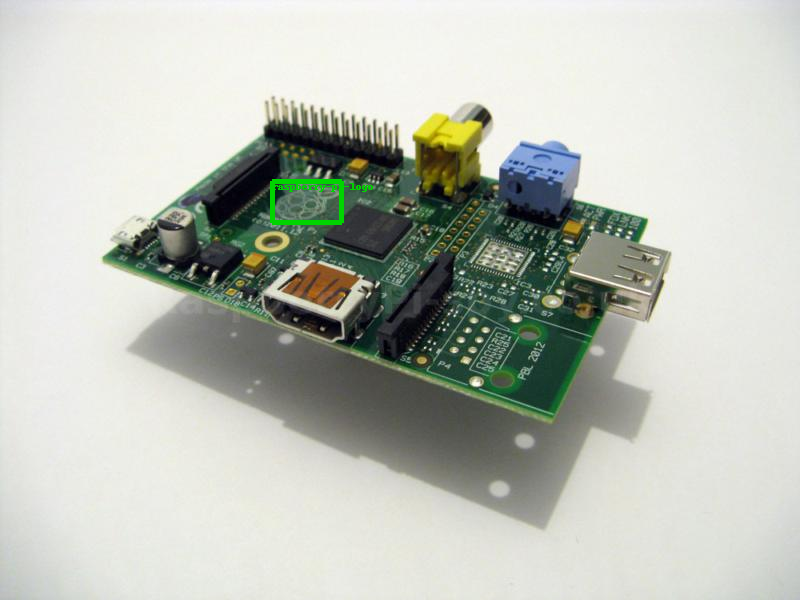

In [35]:
# Let's display the image with labels
image_with_labels

## Step 10: Stop the model

Rekognition Custom Labels service will charge us as long as the model is in the `Running` state. Therefore, we should stop it once it in no more being used. To do that, click the **Stop** button on the model.

![](images/2023-04-26-amazon-rekognition-custom-labels/mode-stop.png)